In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import plotly.express as px


from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
df = pd.read_csv('sales_data_sample.csv', encoding = 'unicode_escape', parse_dates=['ORDERDATE'])
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [3]:
df.isnull().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [4]:
df_drop  = ['ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE', 'CITY', 'TERRITORY', 'PHONE', 'STATE', 'CONTACTFIRSTNAME', 'CONTACTLASTNAME', 'CUSTOMERNAME', 'ORDERNUMBER']
df = df.drop(df_drop, axis=1)
df.head(3)

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,France,Medium


#### Drop georaphic features and names, phone

In [5]:
df.shape

(2823, 14)

In [6]:
df.isna().sum()

QUANTITYORDERED    0
PRICEEACH          0
ORDERLINENUMBER    0
SALES              0
ORDERDATE          0
STATUS             0
QTR_ID             0
MONTH_ID           0
YEAR_ID            0
PRODUCTLINE        0
MSRP               0
PRODUCTCODE        0
COUNTRY            0
DEALSIZE           0
dtype: int64

#### Drop unbalanced feature

In [7]:
df.drop(columns=['STATUS'], axis=1, inplace=True)

In [8]:
print('Columns resume: ', df.shape[1])

Columns resume:  13


### Prepare data

In [9]:
def dummies(x):
  dummy = pd.get_dummies(df[x])
  df.drop(columns=x, inplace=True)
  return pd.concat([df, dummy], axis = 1)

In [10]:
df =  dummies('COUNTRY')

In [11]:
df =  dummies('PRODUCTLINE')

In [12]:
df =  dummies('DEALSIZE')

In [13]:
df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,...,False,True,False,False,False,False,False,False,False,True
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,...,False,True,False,False,False,False,False,False,False,True
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,...,False,True,False,False,False,False,False,False,True,False
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,...,False,True,False,False,False,False,False,False,True,False
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,...,False,True,False,False,False,False,False,False,True,False


In [14]:
y = pd.Categorical(df['PRODUCTCODE'])
y

['S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', ..., 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212']
Length: 2823
Categories (109, object): ['S10_1678', 'S10_1949', 'S10_2016', 'S10_4698', ..., 'S700_3962', 'S700_4002', 'S72_1253', 'S72_3212']

In [15]:
df['PRODUCTCODE'] = pd.Categorical(df['PRODUCTCODE']).codes

In [16]:
df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,0,...,False,True,False,False,False,False,False,False,False,True
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,0,...,False,True,False,False,False,False,False,False,False,True
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,0,...,False,True,False,False,False,False,False,False,True,False
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,0,...,False,True,False,False,False,False,False,False,True,False
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,0,...,False,True,False,False,False,False,False,False,True,False


In [17]:
df.drop('ORDERDATE', axis=1, inplace=True)

#### drop 'ORDERDATE', 'QTR_ID' because we have 'MONTH' etc.

In [18]:
df.drop('QTR_ID', axis=1, inplace=True)

In [19]:
df.shape

(2823, 37)

## Use K-MEANS algorithm

In [20]:
scaler =  StandardScaler()
df_scaled = scaler.fit_transform(df)

In [21]:
scores = []
range_values = range(1, 15)
for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(df_scaled)
  scores.append(kmeans.inertia_)

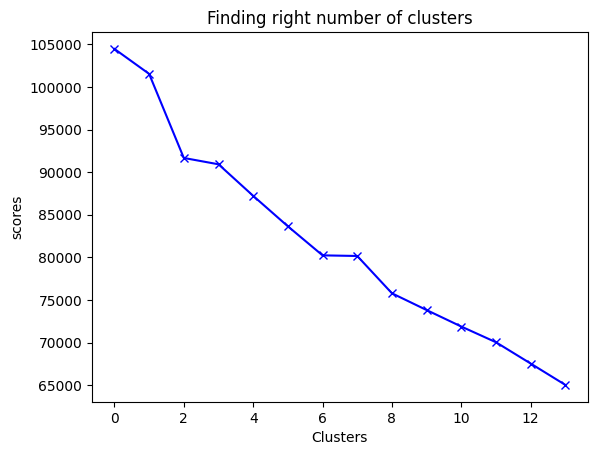

In [22]:
plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores')
plt.show();

#### The elbow method

In [23]:
kmeans = KMeans(4)
kmeans.fit(df_scaled)

KMeans(n_clusters=4)

In [24]:
labels = kmeans.labels_
labels

array([1, 1, 2, ..., 2, 1, 2])

In [25]:
kmeans.cluster_centers_.shape

(4, 37)

In [26]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns= [df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,-0.446356,-0.735656,0.054972,-0.806901,0.521759,-0.470949,-0.639769,0.330824,0.035882,0.010165,...,-0.130362,-0.165618,0.025067,0.106562,0.089016,-0.015541,0.166174,-0.242672,-0.980703,1.096370
1,-0.500368,-0.725889,0.025781,-0.821495,-0.776669,0.690917,-0.544578,0.249680,0.006710,-0.069467,...,-0.242900,0.292837,0.153536,-0.006756,0.050938,-0.082935,-0.018279,-0.242672,-0.980703,1.096370
2,0.438987,0.503532,-0.031271,0.368452,-0.034690,0.050901,0.038997,0.120578,0.017313,-0.071019,...,-0.520371,0.122994,0.093577,0.116205,0.003997,0.260086,0.159003,-0.237985,1.017528,-0.912100
3,0.300641,0.745200,-0.042002,1.114087,0.041328,-0.058462,1.176311,-0.793560,-0.075805,0.150778,...,1.140693,-0.219063,-0.296792,-0.300637,-0.157552,-0.303663,-0.429149,0.855231,0.484091,-0.879706


#### Invert the data

In [27]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data=cluster_centers, columns=[df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30.745431,68.819843,6.698433,2067.949008,9.000000,2003.485640,75.009138,64.220627,0.074413,0.020888,...,0.280679,0.063969,0.116188,1.122715e-01,0.041775,0.101828,0.283290,2.636780e-16,-9.992007e-16,1.000000e+00
1,30.219368,69.016858,6.575099,2041.073458,4.252964,2004.298419,78.833992,61.658103,0.067194,0.009881,...,0.227273,0.211462,0.156126,8.102767e-02,0.035573,0.081028,0.207510,-1.179612e-16,-8.881784e-16,1.000000e+00
2,39.368421,93.815134,6.334049,4232.408271,6.965628,2003.850698,102.282492,57.581096,0.069817,0.009667,...,0.095596,0.156821,0.137487,1.149302e-01,0.027927,0.186896,0.280344,1.074114e-03,9.989259e-01,3.497203e-15
3,38.020968,98.689758,6.288710,5605.523613,7.243548,2003.774194,147.980645,28.712903,0.046774,0.040323,...,0.883871,0.046774,0.016129,9.159340e-16,0.001613,0.012903,0.038710,2.516129e-01,7.322581e-01,1.612903e-02


In [28]:
sales_of_cluster = pd.concat([df, pd.DataFrame({'cluster': labels})], axis=1)
sales_of_cluster.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2,2871.00,2,2003,95,0,False,False,...,True,False,False,False,False,False,False,False,True,1
1,34,81.35,5,2765.90,5,2003,95,0,False,False,...,True,False,False,False,False,False,False,False,True,1
2,41,94.74,2,3884.34,7,2003,95,0,False,False,...,True,False,False,False,False,False,False,True,False,2
3,45,83.26,6,3746.70,8,2003,95,0,False,False,...,True,False,False,False,False,False,False,True,False,2
4,49,100.00,14,5205.27,10,2003,95,0,False,False,...,True,False,False,False,False,False,False,True,False,2
